QUESTION 2:

IMPORT BASIC AND REQUIRED LIBRARIES

In [76]:
!pip install rasterio
!pip install whitebox
!pip install pysheds

In [ ]:
from pysheds.grid import Grid

In [19]:
#import Libraries
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib_map_utils as mu # To draw north arrow
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from matplotlib.colors import ListedColormap 
from rasterio.warp import transform_bounds
from pysheds.grid import Grid
from whitebox.whitebox_tools import WhiteboxTools
from shapely.geometry import Point
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [79]:
path = "C:/GIS/GIS FINAL PROJECT/FINAL SUBMISSION/QUES.2"
os.chdir(path)

In [4]:
dem_files = ['n30_w095_1arc_v2.bil', 'n30_w095_3arc_v2.bil']

In [5]:
# List of DEM files
dem_files = ['n30_w095_1arc_v2.bil', 'n30_w095_3arc_v2.bil']
for dem_file in dem_files:
    with rasterio.open(dem_file) as src:
        crs = src.crs  # Get the CRS
        print(f"CRS of {dem_file}: {crs}")


CRS of n30_w095_1arc_v2.bil: OGC:CRS84
CRS of n30_w095_3arc_v2.bil: OGC:CRS84


In [6]:
datasets = [rasterio.open(file) for file in dem_files]

In [7]:
mosaic, out_transform = merge(datasets)

In [8]:
out_meta = datasets[0].meta.copy()
out_meta.update({
    'driver': 'GTiff',
    'height': mosaic.shape[1],
    'width': mosaic.shape[2],
    'transform': out_transform
})

In [9]:
with rasterio.open('mosaic_output.tif', 'w', **out_meta) as dest:
                   dest.write(mosaic)

In [10]:
for dataset in datasets:
    dataset.close()#Import packages

In [11]:
raster_path = 'mosaic_output.tif' # Replace with your raster file path
with rasterio.open(raster_path) as src:
    #Read the data
    data = src.read(1) # Read the first band (adjust band index if needed)

    #Get the metadata
    metadata = src.profile
    print('Metadata:', metadata)

Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3603, 'height': 3603, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000277777777777778, 0.0, -95.00041666666667,
       0.0, -0.000277777777777778, 31.000416666666666), 'blockxsize': 3603, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


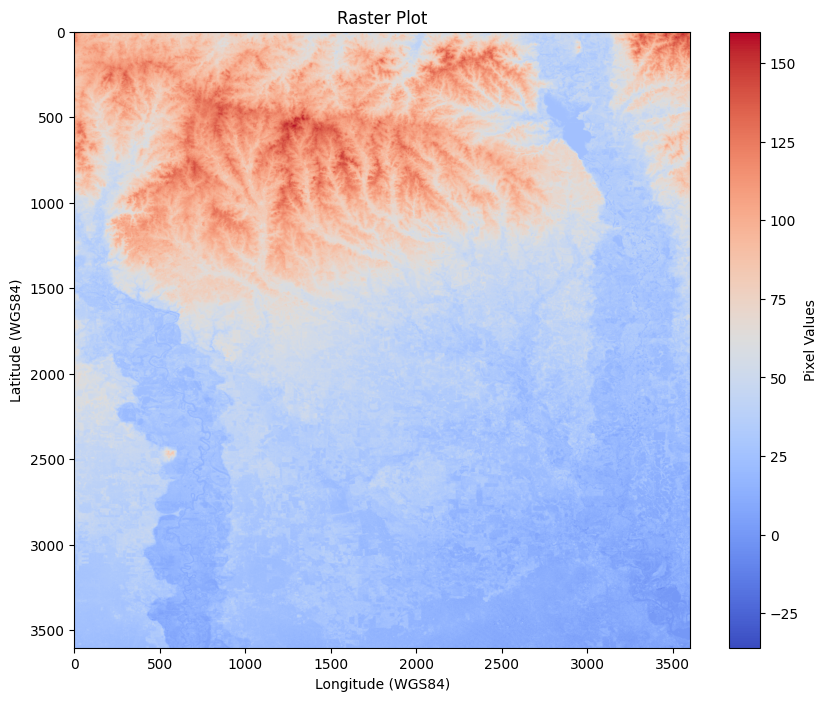

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap = 'coolwarm') #Adjust the colormap as needed
plt.colorbar(label = 'Pixel Values')
plt.xlabel('Longitude (WGS84)')
plt.ylabel('Latitude (WGS84)')
plt.title('Raster Plot')
plt.show()

In [81]:
# plot the county and city
gdff = gpd.read_file("LumbertonCity.gpkg")
gdf = gpd.read_file("HardinCounty.gpkg")

# Reproject both GeoDataFrames to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)
gdff = gdff.to_crs(epsg=4326)

# Confirm the CRS
print("CRS of County GeoDataFrame:", gdf.crs)
print("CRS of City GeoDataFrame:", gdff.crs)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='black', alpha=0.5, label='Orange County')
gdff.plot(ax=ax, color='blue', alpha=0.5, label='Orange City')
ax.set_title("Lumberton City and Hardin County, TX")
plt.show()

DriverError: LumbertonCity.gpkg: No such file or directory

In [89]:
#Load the GeoDataFrame (city boundary from GeoPackage)
gpk_path = 'LumbertonCity.gpkg'  # Replace with the path to your GeoPackage
gdf = gpd.read_file(gpk_path)
raster_path = 'mosaic_output.tif'  # Replace with your DEM file path

with rasterio.open(raster_path) as src:
    geo = gdf.geometry.unary_union 
    out_image, out_transform = mask(src, [geo], crop=True, nodata=-9999)
    out_metadata = src.profile.copy()
    out_metadata.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "nodata": -9999  
    })
    clipped_raster_path = "clipped_dem_inside_hardin.tif"
    with rasterio.open(clipped_raster_path, 'w', **out_metadata) as dest:
        dest.write(out_image)

#Prepare the data for plotting
data = out_image[0] 
data_masked = np.where(data == -9999, np.nan, data) 
terrain_cmap = plt.cm.terrain(np.linspace(0, 1, 256))  
terrain_cmap[0, :] = [1, 1, 1, 1] 
custom_cmap = ListedColormap(terrain_cmap)
min_x, min_y = out_transform * (0, data.shape[0])  
max_x, max_y = out_transform * (data.shape[1], 0)  

# Plot with extent for geospatial axes
plt.figure(figsize=(10, 8))
plt.imshow(data_masked, cmap='twilight', extent=(min_x, max_x, min_y, max_y), interpolation="none")
plt.colorbar(label='Elevation (m)')
plt.title('Clipped DEM Inside Lumberton, TX')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

DriverError: LumbertonCity.gpkg: No such file or directory

Below working with the help of ChatGpt

In [26]:
masked_data = np.ma.masked_equal(data, -9999)  # Mask the nodata value (-9999)
row, col = np.unravel_index(np.argmin(masked_data), data.shape)
lowest_point_coords = rasterio.transform.xy(out_transform, row, col, offset='center')
masked_data_above_zero = np.ma.masked_less_equal(data, 0)
row_above_zero, col_above_zero = np.unravel_index(np.argmin(masked_data_above_zero), data.shape)
lowest_point_coords_above_zero = rasterio.transform.xy(out_transform, row_above_zero, col_above_zero, offset='center')
lowest_point = data[row, col]
lowest_point_above_zero = data[row_above_zero, col_above_zero]
print(f"The lowest elevation point above MSL inside Lumberton City is at {lowest_point_coords_above_zero} with elevation {lowest_point_above_zero:.2f} meters.")

The lowest elevation point above MSL inside Lumberton City is at (-94.22694444444444, 30.24083333333333) with elevation 13.00 meters.


In [25]:
grid = Grid.from_raster('n30_w095_1arc_v2.tif')
dem = grid.read_raster('n30_w095_1arc_v2.tif')

NameError: name 'Grid' is not defined

NameError: name 'dem' is not defined

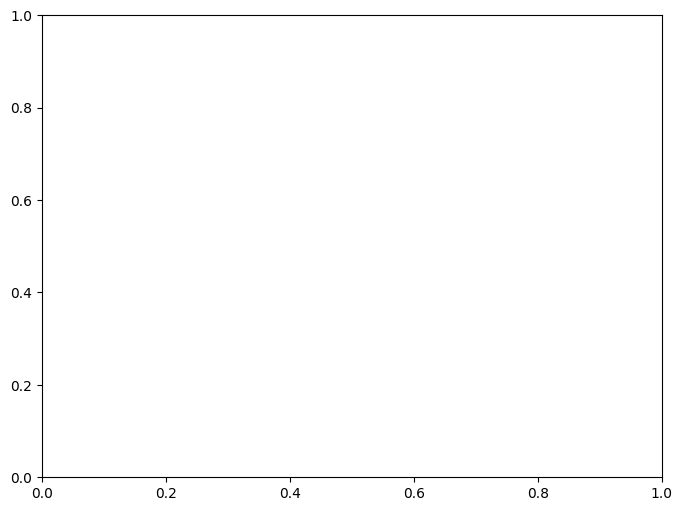

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

FILLED PITS AND CALCULATE DEPRESSION

In [13]:
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem) 
inflated_dem = grid.resolve_flats(flooded_dem)

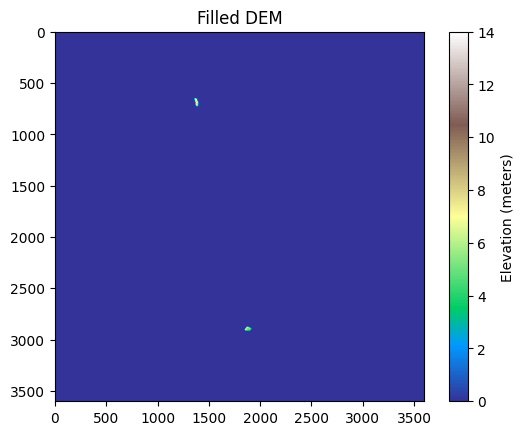

In [32]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

CALCULATE FLOW ACCUMULATION

In [ ]:
acc = grid.accumulation(fdir, dirmap=dirmap)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

DELINEATE CATCHMENT

In [ ]:
x, y = -93.72055555555555, 30.13888888888889
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')
grid.clip_to(catch)
clipped_catch = grid.view(catch)

EXTRACTING RIVER NETWORK

In [ ]:
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

In [ ]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))
gdff.plot(ax=ax, color='blue', alpha=0.5, label='Orange City')

ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

CALCULATE DISTANCE TO OUTLET FROM EACH CELL

In [ ]:
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')